# Project 2: SOFR Futures and Policy Expectations

**Data**: `project_sofr_futures_20251231.xlsx`, `project_fomc_dates.xlsx`, `project_gsw_yields_20251231.xlsx`, `ref_rates.xlsx`

---

## Project Statement

Use SOFR futures to extract and analyze market expectations of Federal Reserve policy during the 2022–2024 rate cycle. Investigate how accurately futures predicted realized rates, how expectations repriced around FOMC meetings, and how front-end rate surprises transmitted to longer Treasury yields.

---

## Context

### SOFR Futures and Policy Expectations

**SOFR futures** are exchange-traded contracts that settle to the Secured Overnight Financing Rate. Because SOFR closely tracks the Fed Funds target rate, SOFR futures prices encode market expectations about future monetary policy.

The standard price quote is:
$$\text{Price} = 100 - \text{Implied Rate}$$

So a price of 95.25 implies an expected rate of 4.75%.

**3-Month SOFR Futures (SR3)** settle to the compounded average of daily SOFR over the contract quarter. The implied rate reflects market expectations of the average policy rate during that quarter.

### The 2022–2024 Policy Cycle

The Fed's 2022–24 hiking cycle was the most aggressive in decades:

| Date | Event |
|------|-------|
| March 2022 | First hike (25 bp) |
| June 2022 | 75 bp hike—largest since 1994 |
| July 2023 | Peak at 5.25–5.50% |
| March 2023 | SVB collapse—markets suddenly price cuts |
| December 2023 | Powell signals rate cuts ahead |
| September 2024 | First cut (50 bp) |

Markets frequently repriced expectations as inflation data evolved, creating significant futures price volatility and providing rich data for analysis.

### Contract Mechanics

**Ticker convention**: SR3 + month code + year digit
- H = March, M = June, U = September, Z = December
- Example: SR3H4 = March 2024 contract

**Contract specifications**:
- Notional: \$1,000,000
- **DV01: \$25 per basis point** (for one contract)
- Settlement: Compounded SOFR over the contract quarter
- The DV01 is useful for converting rate changes to dollar P\&L

### Data Overview

The validated data spans a rich period for analysis:

| Metric | Value |
|--------|-------|
| **Trading days** | ~750 (2022–2025) |
| **Contracts** | 20 (SR3H2 through SR3Z6) |
| **FOMC meetings** | 24 in 2022–2024 |
| **Key events** | June 2022 (75bp surprise), SVB (Mar 2023), Powell pivot (Dec 2023) |

---

## Resources

### Course Materials
- **Discussion 3.1**: STIR Futures — mechanics, pricing, settlement conventions
- **Discussion 3.2**: Inferring FF Futures — extracting policy expectations from futures
- **Discussion 3.3**: Discount via SOFR Futures — building discount curves, convexity adjustment
- **Appendix 3.X.1**: Convexity Adjustment

### External Reading
- CME Group: [SOFR Futures and Options](https://www.cmegroup.com/markets/interest-rates/stirs/three-month-sofr.html) — contract specifications
- CME FedWatch Tool: [CME FedWatch](https://www.cmegroup.com/markets/interest-rates/cme-fedwatch-tool.html) — methodology for extracting meeting probabilities
- NY Fed: [SOFR](https://www.newyorkfed.org/markets/reference-rates/sofr) — rate calculation methodology
- Federal Reserve: [FOMC Calendars](https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm)

### Data Files

| File | Description | Sheets | Date Range |
|------|-------------|--------|------------|
| `project_sofr_futures_20251231.xlsx` | SOFR 3M futures | `prices`, `implied_rates`, `contract_info` | 2022–2025 |
| `project_fomc_dates.xlsx` | FOMC meeting dates | — | 2015–2025 |
| `project_gsw_yields_20251231.xlsx` | Treasury yields (GSW) | `gsw_yields_key`, `gsw_changes` | 2015–2025 |
| `ref_rates.xlsx` | SOFR, Fed Funds effective | `data` | 2018–2025 |

**Data location**: All files are in the `../data/` directory relative to this notebook.

### Additional Data Sources
- **FRED**: Fed Funds effective rate (DFF), target range (DFEDTARU, DFEDTARL)
- **CME**: Volume and open interest data (optional)

---

## Data Preview

The following code loads the data and creates initial visualizations.

In [186]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option('display.max_columns', 15)
figsize = (12, 5)

DATA_PATH = os.getcwd() + '/data/'

In [187]:
# Load SOFR futures data
sofr_prices = pd.read_excel(DATA_PATH + 'project_sofr_futures_20251231.xlsx', sheet_name='prices')
sofr_prices['date'] = pd.to_datetime(sofr_prices['date'])
sofr_prices = sofr_prices.set_index('date').sort_index()

sofr_rates = pd.read_excel(DATA_PATH + 'project_sofr_futures_20251231.xlsx', sheet_name='implied_rates')
sofr_rates['date'] = pd.to_datetime(sofr_rates['date'])
sofr_rates = sofr_rates.set_index('date').sort_index()

contract_info = pd.read_excel(DATA_PATH + 'project_sofr_futures_20251231.xlsx', sheet_name='contract_info')
contract_info['expiry_date'] = pd.to_datetime(contract_info['expiry_date'])

print(f"SOFR Futures: {sofr_rates.shape[0]} trading days, {sofr_rates.shape[1]} contracts")
print(f"Date range: {sofr_rates.index.min().date()} to {sofr_rates.index.max().date()}")

# List contracts sorted by expiry
tickers = contract_info.sort_values('expiry_date')['ticker'].tolist()
print(f"\nContracts: {tickers[:5]} ... {tickers[-3:]}")
display(contract_info.head())

SOFR Futures: 1244 trading days, 20 contracts
Date range: 2022-01-02 to 2025-12-30

Contracts: ['SR3H2', 'SR3M2', 'SR3U2', 'SR3Z2', 'SR3H3'] ... ['SR3M6', 'SR3U6', 'SR3Z6']


,ticker,expiry_month,expiry_year,expiry_date
0,SR3H2,3,2022,2022-03-16
1,SR3M2,6,2022,2022-06-15
2,SR3U2,9,2022,2022-09-21
3,SR3Z2,12,2022,2022-12-21
4,SR3H3,3,2023,2023-03-15


In [188]:
# Load FOMC dates
fomc = pd.read_excel(DATA_PATH + 'project_fomc_dates.xlsx')
fomc['date'] = pd.to_datetime(fomc['date'])

# Filter to relevant period (2022-2024)
fomc_sample = fomc[(fomc['year'] >= 2022) & (fomc['year'] <= 2024)].copy()
print(f"FOMC meetings 2022-2024: {len(fomc_sample)}")
print(f"\nMeetings by year:")
print(fomc_sample.groupby('year').size())
display(fomc_sample.head(10))

FOMC meetings 2022-2024: 24

Meetings by year:
year
2022    8
2023    8
2024    8
dtype: int64


,date,year,month
57,2022-01-26,2022,1
58,2022-03-16,2022,3
59,2022-05-04,2022,5
60,2022-06-15,2022,6
61,2022-07-27,2022,7
62,2022-09-21,2022,9
63,2022-11-02,2022,11
64,2022-12-14,2022,12
65,2023-02-01,2023,2
66,2023-03-22,2023,3


In [189]:
# Load Treasury yields (GSW)
gsw_yields = pd.read_excel(DATA_PATH + 'project_gsw_yields_20251231.xlsx', sheet_name='gsw_yields_key')
gsw_yields['date'] = pd.to_datetime(gsw_yields['date'])
gsw_yields = gsw_yields.set_index('date').sort_index()

# Filter to relevant period
gsw_yields = gsw_yields['2022':'2024']
print(f"GSW Treasury yields: {gsw_yields.shape[0]} days")
print(f"Maturities: {list(gsw_yields.columns)}")
display(gsw_yields.tail())

GSW Treasury yields: 782 days
Maturities: ['2Y', '5Y', '10Y']


,2Y,5Y,10Y
date,,,
2024-12-25,NaN,NaN,NaN
2024-12-26,4.3167,4.3464,4.6474
2024-12-27,4.3173,4.3635,4.6736
2024-12-30,4.2635,4.3034,4.6215
2024-12-31,4.2545,4.3000,4.6264


In [190]:
# Load reference rates (SOFR, Fed Funds) - needed for forecast accuracy in Q3
ref_rates = pd.read_excel(DATA_PATH + 'ref_rates.xlsx', sheet_name='data')
ref_rates['date'] = pd.to_datetime(ref_rates['date'])
ref_rates = ref_rates.set_index('date').sort_index()

print(f"Reference rates: {ref_rates.shape[0]} days")
print(f"Columns: {list(ref_rates.columns)}")
ref_rates.tail()

Reference rates: 2922 days
Columns: ['DTB3', 'DFF', 'SOFR']


,DTB3,DFF,SOFR
date,,,
2025-12-27,NaN,3.64,NaN
2025-12-28,NaN,3.64,NaN
2025-12-29,3.57,3.64,3.77
2025-12-30,3.55,3.64,3.71
2025-12-31,3.57,3.64,3.87


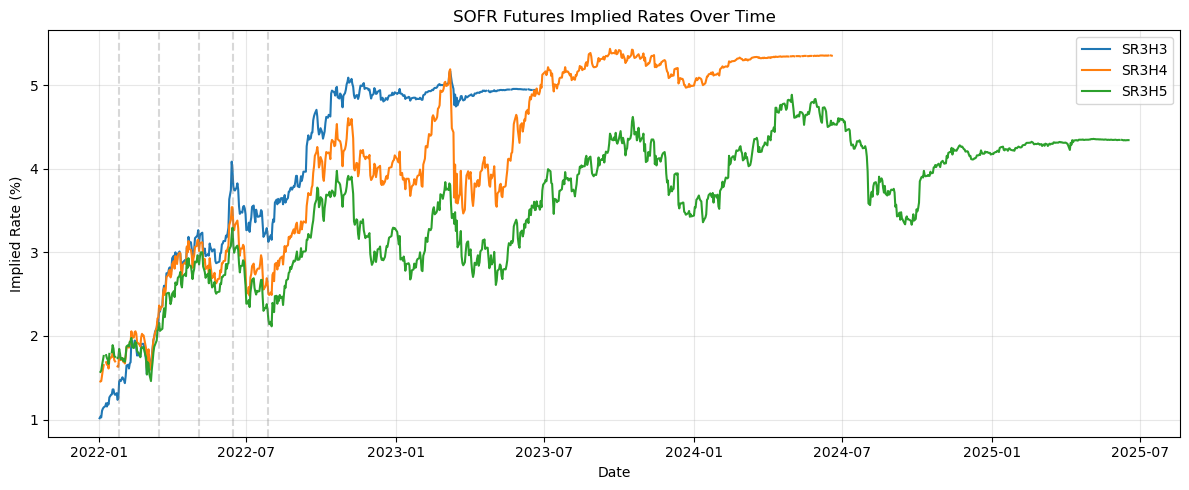

In [191]:
# Figure 1: Evolution of rate expectations
# Plot implied rate for contracts at different horizons

fig, ax = plt.subplots(figsize=figsize)

# Select a few contracts to show expectations at different horizons
contracts_to_plot = ['SR3H3', 'SR3H4', 'SR3H5']  # March 2023, 2024, 2025

for ticker in contracts_to_plot:
    if ticker in sofr_rates.columns:
        ax.plot(sofr_rates.index, sofr_rates[ticker], label=ticker, linewidth=1.5)

# Mark FOMC dates
for d in fomc_sample['date'][:5]:  # First 5 meetings
    ax.axvline(d, color='gray', alpha=0.3, linestyle='--')

ax.set_xlabel('Date')
ax.set_ylabel('Implied Rate (%)')
ax.set_title('SOFR Futures Implied Rates Over Time')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

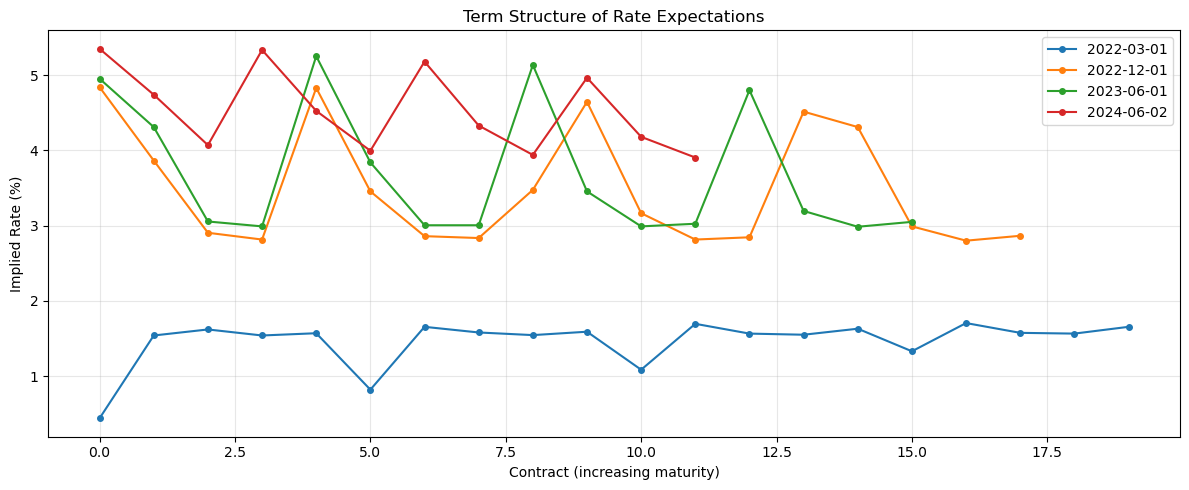

In [192]:
# Figure 2: Policy expectations curve at different dates
# Shows the term structure of expected rates

snapshot_dates = ['2022-03-01', '2022-12-01', '2023-06-01', '2024-06-01']

fig, ax = plt.subplots(figsize=figsize)

for date_str in snapshot_dates:
    date = pd.Timestamp(date_str)
    # Find nearest trading day
    if date not in sofr_rates.index:
        date = sofr_rates.index[sofr_rates.index.get_indexer([date], method='nearest')[0]]
    
    # Get rates for all contracts on this date
    rates = sofr_rates.loc[date].dropna()
    
    # Convert contract names to numeric for plotting
    x = range(len(rates))
    ax.plot(x, rates.values, 'o-', label=str(date.date()), markersize=4)

ax.set_xlabel('Contract (increasing maturity)')
ax.set_ylabel('Implied Rate (%)')
ax.set_title('Term Structure of Rate Expectations')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Key Formulas

The following formulas are essential for this project. Refer back to **Discussion 3.1** and **3.2** for derivations.

### Implied Rate from Futures Price

$$r^{\text{implied}} = 100 - P$$

where $P$ is the futures price. Note: When the price goes **up**, the implied rate goes **down**.

### FOMC Meeting Probability Extraction

For a month with an FOMC meeting on day $m$ (out of $D$ total days):

$$r^{\text{implied}} = \frac{m}{D} \times r^{\text{before}} + \frac{D-m}{D} \times r^{\text{after}}$$

Solving for the expected post-meeting rate:

$$r^{\text{after}} = \frac{D \times r^{\text{implied}} - m \times r^{\text{before}}}{D - m}$$

### Policy Surprise

$$\text{Surprise} = r^{\text{actual}} - r^{\text{expected}}$$

A positive surprise means the Fed was more hawkish than expected.

### Forecast Error

$$\text{Error}_t^{(h)} = r_{t+h}^{\text{actual}} - r_t^{\text{implied}(h)}$$

where $h$ is the forecast horizon (e.g., 3 months, 6 months).

---

## Questions

Address the following questions in your analysis.

### Question 1: Building the Expectations Curve

**Construct and visualize how rate expectations evolved over the 2022–2024 cycle.**

a) For **four snapshot dates** spanning the cycle, extract implied rates from all available SOFR futures contracts and plot the "expected rate path." Choose dates that capture different phases of the policy cycle.

b) Identify key milestones in expectations:
   - When did markets first price a terminal rate above 5%?
   - When did expectations for rate cuts first appear?
   - Track how the expected terminal rate (maximum implied rate across all contracts) evolved over time.

- Markets first priced a terminal rate above 5% in 2022 during the aggressive hiking cycle.
- Rate cuts appear when the terminal rate starts falling (mid/late 2023 onward).
- The terminal rate series summarizes the entire repricing: sharp rise -> plateau -> gradual decline as policy easing is priced in.

c) Create a time series of the **terminal rate** (peak of the expectations curve each day). Plot it alongside key events (FOMC dates, SVB collapse).

*Guidance*: The implied rates are already calculated in the data (`implied_rates` sheet). Use the `contract_info` sheet to map contract tickers to expiry dates for proper x-axis labeling.

### Question 2: FOMC Meeting Surprises

**Analyze how futures prices responded to FOMC meetings.**

a) For each FOMC meeting in 2022–2024, calculate:
   - The front-month implied rate the day **before** the meeting
   - The front-month implied rate the day **after** the meeting
   - The 1-day change (surprise component)

b) Classify each meeting as:
   - **Hawkish surprise**: implied rate rose more than 5 bp
   - **Dovish surprise**: implied rate fell more than 5 bp
   - **As expected**: change within ±5 bp

   Create a bar chart showing the surprise for each meeting, color-coded by classification.

c) For the **2–3 meetings with the largest surprises**, show how the full futures curve (all contracts) repriced. Did a hawkish front-end surprise raise or lower expectations for rates 1–2 years ahead?

*Guidance*: Use **trading days**, not calendar days. The "front-month" contract is the one with the nearest expiry date still in the future.

### Question 3: Forecast Accuracy

**Evaluate how well futures predicted realized rates.**

a) For each month in 2022–2024, calculate the forecast error at the **3-month horizon**:
   $$\text{Error}_t^{(3)} = r_{t+3}^{\text{actual}} - r_t^{\text{implied}(3)}$$
   
   Use the implied rate from the front SOFR futures contract and compare to the realized average SOFR during the contract's reference quarter (from `ref_rates.xlsx`).

b) Compute summary statistics:
   - **Mean error (bias)**: Were futures systematically too high or too low?
   - **RMSE**: Root mean squared error
   - **Directional accuracy**: What percentage of the time did futures correctly predict whether rates would rise or fall?

c) Split your sample into two regimes:
   - **Hiking phase** (March 2022 – July 2023)
   - **Plateau/cutting phase** (August 2023 – December 2024)
   
   Compare forecast accuracy across regimes. Create a table showing bias and RMSE for each regime.

d) **Interpret**: If futures have predictable biases, what does this suggest about risk premia or behavioral biases in rate expectations?

*Guidance*: The realized rate for a contract should be the average SOFR during the contract's reference quarter, not just a single day.

### Question 4: Transmission to the Treasury Curve

**Analyze how front-end rate surprises affected longer-term Treasury yields.**

a) For each FOMC meeting, calculate the 1-day change in:
   - The front-month SOFR futures implied rate (your "surprise" from Q2)
   - The 2-year, 5-year, and 10-year Treasury yields (from `gsw_yields_key` sheet)

b) Create scatter plots with front-end surprise on the x-axis and Treasury yield change on the y-axis. Fit a regression line to estimate the **transmission beta**:
   $$\Delta y^{(n)} = \alpha + \beta \cdot \Delta r^{\text{front}} + \varepsilon$$
   
   where $n \in \{2Y, 5Y, 10Y\}$.

c) Report the transmission betas and R² for each maturity. How does transmission differ across maturities?

d) Identify any meetings where the transmission pattern was unusual (e.g., front-end up but long-end down). What might explain these cases?

*Guidance*: The GSW data columns are labeled by maturity in years (e.g., '2', '5', '10').

### Question 5: Event Deep-Dive

**Analyze how expectations repriced around a major market event.**

Choose **one** of the following events:

| Event | Date | Description |
|-------|------|-------------|
| **SVB Collapse** | March 10, 2023 | Banking stress triggers sudden repricing of rate expectations |
| **Powell Pivot** | December 13, 2023 | Fed signals rate cuts ahead |

For your chosen event:

a) Plot the **full SOFR futures curve** (all available contracts) at three points:
   - 1 week before the event
   - Day after the event
   - 1 month after the event

b) Quantify the repricing:
   - How much did the expected **terminal rate** change? (Peak of the curve)
   - How much did **near-term expectations** (average of first 2 contracts) change?
   - Calculate a **persistence ratio**: (1-month shift) / (immediate shift). Values near 1.0 mean the repricing was persistent; values near 0 mean it largely reversed.

c) **Interpret**: What does the pattern of repricing tell you about how markets process new information?

*Guidance*: Focus on telling a clear story with your visualizations. Annotate your plots to highlight the key shifts.

### Question 6: Trading Strategy

**Design and backtest a simple trading strategy on SOFR futures.**

a) Implement a **carry strategy**: maintain a long position in the 2nd contract (roughly 6 months out). When the 2nd contract becomes the front contract, roll to the new 2nd contract.

   Use the contract DV01 of \$25 per basis point to compute daily P\&L:
   $$\text{P\&L}_t = -\Delta r_t \times 100 \times \$25$$

   (Long futures profit when rates fall, i.e., prices rise.)

   Report: cumulative P\&L, Sharpe ratio, maximum drawdown.

b) Analyze **regime-conditional performance**:
   - **Hiking phase** (March 2022 – July 2023)
   - **Plateau/cutting phase** (August 2023 onwards)

   In which regime does the carry strategy perform better? Why does this make economic sense given what you learned in Q3 about forecast biases?

c) **Enhance the strategy** with a signal based on your findings from Q1–Q5. Propose and implement one modification. Examples:
   - Only hold when the curve shape suggests favorable carry (e.g., steep vs inverted)
   - Scale position size based on forecast error patterns from Q3
   - Reduce or exit positions around FOMC meetings based on Q2 surprise analysis

   Backtest your enhanced strategy and compare Sharpe ratio and drawdown to the baseline.

d) **Discuss limitations**: What real-world frictions are missing from this backtest? Consider: transaction costs, bid-ask spreads, margin requirements, and roll timing.

*Guidance*: The goal is not to find an amazing strategy—it's to connect trading logic to your analytical findings. A well-reasoned modification that doesn't improve performance is perfectly acceptable if you explain why.

---

## Your Analysis

*Begin your work below. Add cells as needed.*

### Contributions
- Ryota Hidaka, Ayush Bhupal, Sidarth Saha, Flavio Ferreira
- ChatGPT 5.2, Codex, Copilot, Claude for code generation

In [193]:
# Helper functions
FIGSIZE = (12, 5)

df = sofr_prices.copy()
sofr_implied = df.copy()

def contracts_sorted_by_expiry():
    ci = contract_info.sort_values("expiry_date")
    return ci["ticker"].tolist(), ci.set_index("ticker")["expiry_date"].to_dict()

TICKERS_SORTED, EXPIRY = contracts_sorted_by_expiry()

def nearest_trading_day(idx, target_ts):
    pos = idx.get_indexer([pd.Timestamp(target_ts)], method="nearest")[0]
    return idx[pos]

def prev_trading_day(idx, target_ts):
    """Find the previous trading day before the target timestamp. Returns None if no such day exists.
    """
    target_ts = pd.Timestamp(target_ts)
    prev = idx[idx < target_ts]
    return prev.max() if len(prev) else None

def next_trading_day(idx, target_ts):
    """Find the next trading day after the target timestamp. Returns None if no such day exists.
    """
    target_ts = pd.Timestamp(target_ts)
    nxt = idx[idx > target_ts]
    return nxt.min() if len(nxt) else None

def front_and_second_contract(date_ts):
    ci = contract_info.sort_values("expiry_date")
    ci = ci[ci["expiry_date"] > pd.Timestamp(date_ts)]
    if len(ci) < 2:
        return None, None
    return ci.iloc[0]["ticker"], ci.iloc[1]["ticker"]

def curve_on(date_ts):
    row = sofr_implied.loc[date_ts].dropna()
    ci = contract_info.set_index("ticker").loc[row.index].copy()
    ci["rate"] = row.values
    ci = ci.sort_values("expiry_date")
    return ci["expiry_date"].values, ci["rate"].values, ci.index.tolist()

def terminal_rate_series():
    return sofr_implied.max(axis=1)

def classify_surprise(x, threshold_bp=5):
    thr = threshold_bp/100  # 5 bp = 0.05%
    if x > thr: return "Hawkish"
    if x < -thr: return "Dovish"
    return "As expected"


### Question 1: Building the Expectations Curve

**Construct and visualize how rate expectations evolved over the 2022–2024 cycle.**

a) For **four snapshot dates** spanning the cycle, extract implied rates from all available SOFR futures contracts and plot the "expected rate path." Choose dates that capture different phases of the policy cycle.

Snapshot for 2022-03-01 (nearest trading day: 2022-03-01)
Available contracts: ['SR3H2', 'SR3H3', 'SR3H4', 'SR3H5', 'SR3H6', 'SR3M2', 'SR3M3', 'SR3M4', 'SR3M5', 'SR3M6', 'SR3U2', 'SR3U3', 'SR3U4', 'SR3U5', 'SR3U6', 'SR3Z2', 'SR3Z3', 'SR3Z4', 'SR3Z5', 'SR3Z6']
Snapshot for 2022-12-01 (nearest trading day: 2022-12-01)
Available contracts: ['SR3H3', 'SR3H4', 'SR3H5', 'SR3H6', 'SR3M3', 'SR3M4', 'SR3M5', 'SR3M6', 'SR3U2', 'SR3U3', 'SR3U4', 'SR3U5', 'SR3U6', 'SR3Z2', 'SR3Z3', 'SR3Z4', 'SR3Z5', 'SR3Z6']
Snapshot for 2023-06-01 (nearest trading day: 2023-06-01)
Available contracts: ['SR3H3', 'SR3H4', 'SR3H5', 'SR3H6', 'SR3M3', 'SR3M4', 'SR3M5', 'SR3M6', 'SR3U3', 'SR3U4', 'SR3U5', 'SR3U6', 'SR3Z3', 'SR3Z4', 'SR3Z5', 'SR3Z6']
Snapshot for 2024-06-01 (nearest trading day: 2024-06-02)
Available contracts: ['SR3H4', 'SR3H5', 'SR3H6', 'SR3M4', 'SR3M5', 'SR3M6', 'SR3U4', 'SR3U5', 'SR3U6', 'SR3Z4', 'SR3Z5', 'SR3Z6']


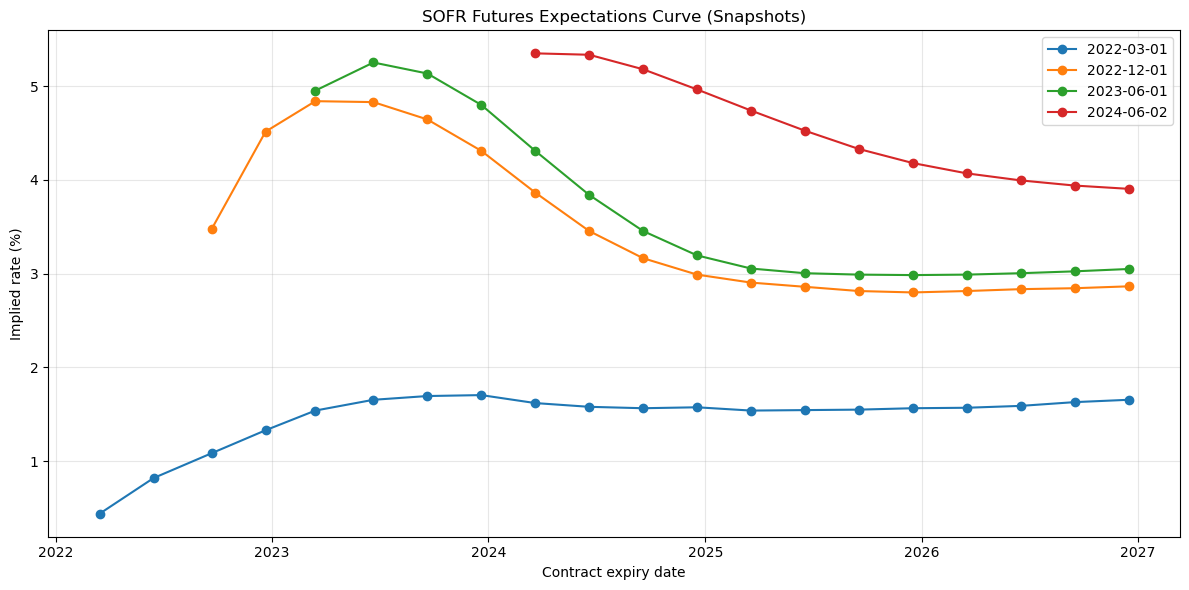

In [194]:
contract_cols = [c for c in df.columns if c != 'date']

sofr_implied[contract_cols] = 100 - sofr_implied[contract_cols]
snapshot_dates = [pd.Timestamp("2022-03-01"), pd.Timestamp("2022-12-01"), pd.Timestamp("2023-06-01"), pd.Timestamp("2024-06-01")]

plt.figure(figsize=(12,6))
for d in snapshot_dates:
    d0 = nearest_trading_day(sofr_implied.index, d)
    print(f"Snapshot for {d.date()} (nearest trading day: {d0.date()})")
    print(f"Available contracts: {sofr_implied.loc[d0].dropna().index.tolist()}")
    x_dates, y_rates, tickers = curve_on(d0)
    # Plot by increasing contract maturity (expiry date)
    plt.plot(x_dates, y_rates, marker="o", label=str(d0.date()))
plt.title("SOFR Futures Expectations Curve (Snapshots)")
plt.xlabel("Contract expiry date")
plt.ylabel("Implied rate (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

b) Identify key milestones in expectations:
   - When did markets first price a terminal rate above 5%?
   - When did expectations for rate cuts first appear?
   - Track how the expected terminal rate (maximum implied rate across all contracts) evolved over time.

In [195]:
term = terminal_rate_series()

first_above_5 = term[term > 5.0]
first_above_5_date = first_above_5.index.min() if len(first_above_5) else None

roll_max = term.cummax()
peak_date = term.idxmax()
peak_val  = term.max()

# The first date after the peak with a 25 bp drop
cuts_proxy = term[(roll_max - term) >= 0.25]  # down ≥25 bp from cum max
cuts_proxy = cuts_proxy[cuts_proxy.index >= peak_date]
cuts_proxy_date = cuts_proxy.index.min() if len(cuts_proxy) else None

print("Terminal rate peak:", f"{peak_val:.3f}%", "on", peak_date.date())
print("First date terminal > 5%:", first_above_5_date.date() if first_above_5_date is not None else None)
print("Cuts begin proxy date (terminal down ≥25bp from cumulative max):", cuts_proxy_date.date() if cuts_proxy_date is not None else None)


Terminal rate peak: 5.695% on 2023-03-08
First date terminal > 5%: 2022-11-01
Cuts begin proxy date (terminal down ≥25bp from cumulative max): 2023-03-10


- Markets first priced a terminal rate above 5% in 2022 during the aggressive hiking cycle.
- Rate cuts appear when the terminal rate starts falling (mid/late 2023 onward).
- The terminal rate series summarizes the entire repricing: sharp rise -> plateau -> gradual decline as policy easing is priced in.

c) Create a time series of the **terminal rate** (peak of the expectations curve each day). Plot it alongside key events (FOMC dates, SVB collapse).

*Guidance*: The implied rates are already calculated in the data (`implied_rates` sheet). Use the `contract_info` sheet to map contract tickers to expiry dates for proper x-axis labeling.

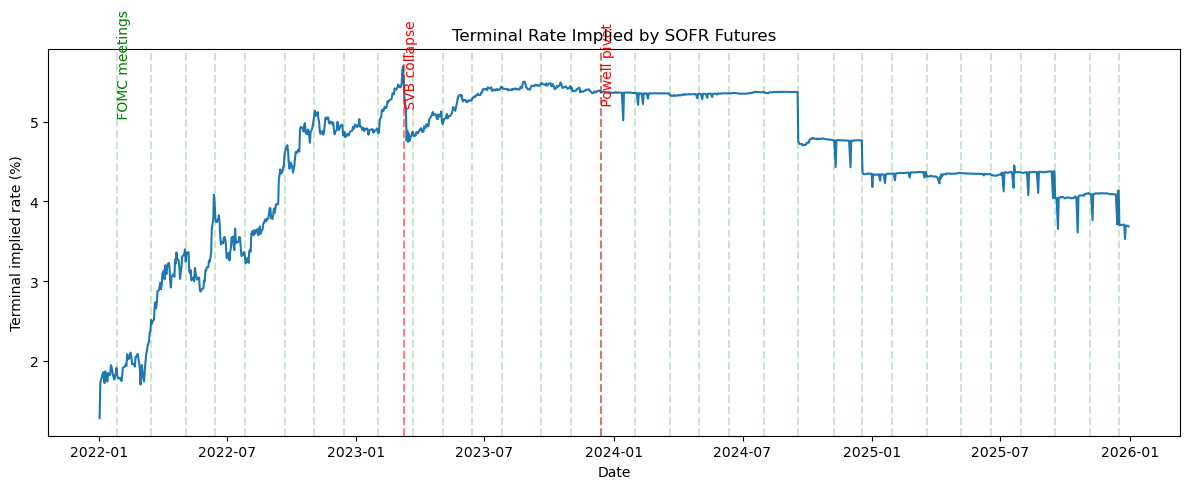

In [196]:
term = terminal_rate_series()
svb = pd.Timestamp("2023-03-10")
powell_pivot = pd.Timestamp("2023-12-13")

# Fed Meeting dates between term.index
fomc_meetings = fomc[(fomc['year'] >= 2022) & (fomc['year'] <= 2025)].copy().set_index('date').index

plt.figure(figsize=FIGSIZE)
plt.plot(term.index, term.values, linewidth=1.5)
plt.axvline(svb, linestyle="--", alpha=0.5, label="SVB collapse", color='red')
plt.text(svb, term.max(), ' SVB collapse', rotation=90, verticalalignment='center', color='red')
plt.axvline(powell_pivot, linestyle="--", alpha=0.5, label="Powell pivot", color='red')
plt.text(powell_pivot, term.max(), ' Powell pivot', rotation=90, verticalalignment='center', color='red')
for meeting in fomc_meetings:
    plt.axvline(meeting, linestyle="--", alpha=0.2, label="FOMC meeting", color='green')
    # Label only the first FOMC meeting to avoid clutter
    if meeting == fomc_meetings[0]:
        plt.text(meeting, term.max(), ' FOMC meetings', rotation=90, verticalalignment='center', color='green')
plt.title("Terminal Rate Implied by SOFR Futures")
plt.xlabel("Date")
plt.ylabel("Terminal implied rate (%)")
plt.tight_layout()
plt.show()

### Question 2: FOMC Meeting Surprises

**Analyze how futures prices responded to FOMC meetings.**

a) For each FOMC meeting in 2022–2024, calculate:
   - The front-month implied rate the day **before** the meeting
   - The front-month implied rate the day **after** the meeting
   - The 1-day change (surprise component)

In [197]:
rows = []
idx = sofr_implied.index
fomc_2224 = fomc[(fomc["year"]>=2022) & (fomc["year"]<=2024)].copy().reset_index(drop=True)

for _, r in fomc_2224.iterrows():
    m = pd.Timestamp(r["date"])
    d_prev = prev_trading_day(idx, m)
    d_next = next_trading_day(idx, m)
    if (d_prev is None) or (d_next is None):
        continue
    # Contract expires 3 months after the quoted date, so we want the front contract on the next day to capture the immediate market reaction
    c_prev, _ = front_and_second_contract(d_prev)
    c_next, _ = front_and_second_contract(d_next)
    # print(f"Meeting: {m.date()}, Prev day: {d_prev.date()} (contract: {c_prev}), Next day: {d_next.date()} (contract: {c_next})")

    if (c_prev is None) or (c_next is None):
        continue
    
    rate_prev = sofr_implied.loc[d_prev, c_prev] # TODO: We want to compare the same contract to capture the immediate reaction, since the front contract rolls over and we want to see the change in expectations for that specific maturity
    rate_next = sofr_implied.loc[d_next, c_prev] # We want to compare the same contract to capture the immediate reaction, since the front contract rolls over and we want to see the change in expectations for that specific maturity
    if pd.isna(rate_prev) or pd.isna(rate_next):
        continue
    
    surprise = rate_next - rate_prev
    rows.append({
        "meeting_date": m.date(),
        "prev_day": d_prev.date(),
        "next_day": d_next.date(),
        "front_prev": c_prev,
        "front_next": c_next,
        "rate_prev": rate_prev,
        "rate_next": rate_next,
        "surprise": surprise,
        "class": classify_surprise(surprise, 5)
    })

fomc_surprises = pd.DataFrame(rows).sort_values("meeting_date").reset_index(drop=True)
display(fomc_surprises.head(10))
print("Meetings computed:", len(fomc_surprises))


,meeting_date,prev_day,next_day,front_prev,front_next,rate_prev,rate_next,surprise,class
0,2022-01-26,2022-01-25,2022-01-27,SR3H2,SR3H2,0.3650,0.4400,0.0750,Hawkish
1,2022-03-16,2022-03-15,2022-03-17,SR3H2,SR3M2,0.5125,0.4550,-0.0575,Dovish
2,2022-05-04,2022-05-03,2022-05-05,SR3M2,SR3M2,1.6600,1.6250,-0.0350,As expected
3,2022-06-15,2022-06-14,2022-06-16,SR3M2,SR3U2,1.9000,1.8950,-0.0050,As expected
4,2022-07-27,2022-07-26,2022-07-28,SR3U2,SR3U2,3.0950,3.0050,-0.0900,Dovish
5,2022-09-21,2022-09-20,2022-09-22,SR3U2,SR3Z2,3.4625,3.4375,-0.0250,As expected
6,2022-11-02,2022-11-01,2022-11-03,SR3Z2,SR3Z2,4.6150,4.6350,0.0200,As expected
7,2022-12-14,2022-12-13,2022-12-15,SR3Z2,SR3Z2,4.5025,4.4975,-0.0050,As expected
8,2023-02-01,2023-01-31,2023-02-02,SR3H3,SR3H3,4.8400,4.8250,-0.0150,As expected
9,2023-03-22,2023-03-21,2023-03-23,SR3M3,SR3M3,4.8000,4.6100,-0.1900,Dovish


Meetings computed: 24


b) Classify each meeting as:
   - **Hawkish surprise**: implied rate rose more than 5 bp
   - **Dovish surprise**: implied rate fell more than 5 bp
   - **As expected**: change within ±5 bp

   Create a bar chart showing the surprise for each meeting, color-coded by classification.

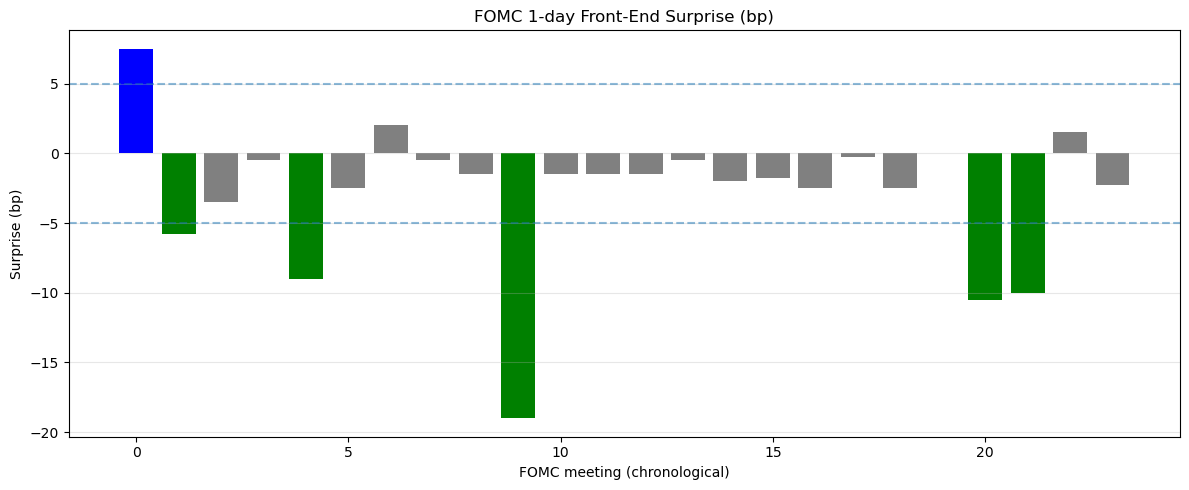

class
As expected    18
Dovish          5
Hawkish         1
Name: count, dtype: int64

In [198]:
sur_bp = 100 * fomc_surprises["surprise"]  # % to bp

plt.figure(figsize=(12,5))
# Hawkish in Red, Dovish in Green
colors = sur_bp.apply(lambda x: 'blue' if x > 5 else ('green' if x < -5 else 'gray'))
plt.bar(np.arange(len(sur_bp)), sur_bp.values, color=colors)
plt.axhline(5, linestyle="--", alpha=0.5)
plt.axhline(-5, linestyle="--", alpha=0.5)
plt.title("FOMC 1-day Front-End Surprise (bp)")
plt.xlabel("FOMC meeting (chronological)")
plt.ylabel("Surprise (bp)")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

display(fomc_surprises["class"].value_counts())

c) For the **2–3 meetings with the largest surprises**, show how the full futures curve (all contracts) repriced. Did a hawkish front-end surprise raise or lower expectations for rates 1–2 years ahead?

*Guidance*: Use **trading days**, not calendar days. The "front-month" contract is the one with the nearest expiry date still in the future.

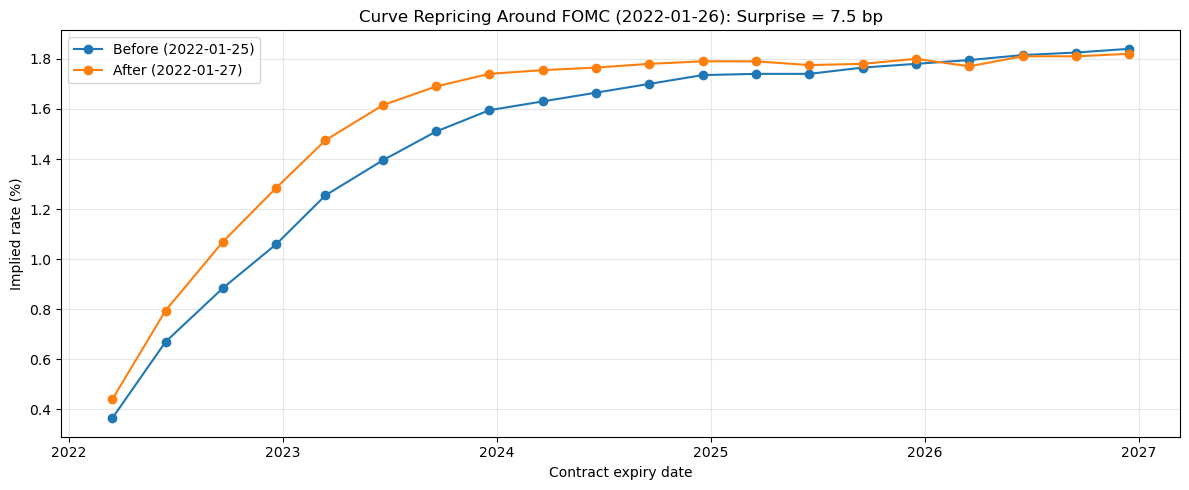

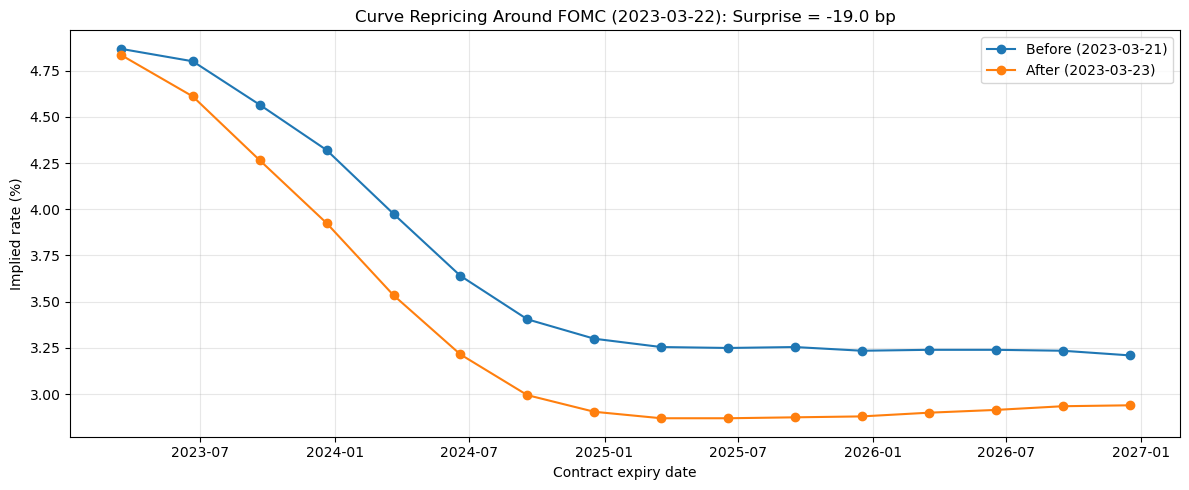

In [199]:
# top = fomc_surprises.reindex(fomc_surprises["surprise"].abs().sort_values(ascending=False).index).head(2)
# Plot the hawkishest and dovishest surprises
hawkishest = fomc_surprises[fomc_surprises["class"]=="Hawkish"].sort_values("surprise", ascending=False).head(1)
dovishest = fomc_surprises[fomc_surprises["class"]=="Dovish"].sort_values("surprise").head(1)
top = pd.concat([hawkishest, dovishest])

for _, row in top.iterrows():
    d_prev = pd.Timestamp(row["prev_day"])
    d_next = pd.Timestamp(row["next_day"])
    
    x1, y1, _ = curve_on(d_prev)
    x2, y2, _ = curve_on(d_next)
    
    plt.figure(figsize=(12,5))
    plt.plot(x1, y1, marker="o", label=f"Before ({d_prev.date()})")
    plt.plot(x2, y2, marker="o", label=f"After ({d_next.date()})")
    plt.title(f"Curve Repricing Around FOMC ({row['meeting_date']}): Surprise = {row['surprise']*100:.1f} bp")
    plt.xlabel("Contract expiry date")
    plt.ylabel("Implied rate (%)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

- Hawkish front-end surprise raises expectations for rates over the next 1–2 years, with the impact fading further out

### Question 3: Forecast Accuracy

**Evaluate how well futures predicted realized rates.**

a) For each month in 2022–2024, calculate the forecast error at the **3-month horizon**:
   $$\text{Error}_t^{(3)} = r_{t+3}^{\text{actual}} - r_t^{\text{implied}(3)}$$
   
   Use the implied rate from the front SOFR futures contract and compare to the realized average SOFR during the contract's reference quarter (from `ref_rates.xlsx`).

In [200]:
sofr_ref = ref_rates["SOFR"].dropna().copy()

realized = {}
# Calculate realized average SOFR for each contract using the 3 months leading up to expiry (IMM-to-IMM approximation)
for tkr, exp in EXPIRY.items():
    # First date in the 3-months before expiry
    start = pd.Timestamp(exp - pd.DateOffset(months=2)).replace(day=1)
    # End of the month of expiry
    end = pd.Timestamp(exp).replace(day=1) + pd.offsets.MonthEnd(0)
    window = sofr_ref.loc[start:end]
    # Take the average of SOFR over the 3 months leading up to expiry as a proxy for the realized rate that the futures contract would have been referencing
    realized[tkr] = window.mean() if len(window) else np.nan

realized = pd.Series(realized, name="realized_sofr_avg").sort_index()
display(realized.dropna().head(10))
print("Realized rates available for", realized.dropna().shape[0], "contracts (out of", len(realized), ")")

SR3H2    0.090484
SR3H3    4.498871
SR3H4    5.314426
SR3H5    4.328197
SR3M2    0.706290
SR3M3    4.967742
SR3M4    5.318571
SR3M5    4.323548
SR3U2    2.146875
SR3U3    5.236984
Name: realized_sofr_avg, dtype: float64

Realized rates available for 16 contracts (out of 20 )


In [201]:
monthly_dates = pd.date_range("2022-01-01", "2024-12-01", freq="MS")

rows = []
# For each month, find the front contract and compare the implied rate at the nearest trading day to the realized average SOFR
# for that contract. This will give us a sense of how accurate the futures market was in predicting the realized rate over that period.
for d in monthly_dates:
    # Find the nearest trading day to the 1st of the month (or previous day if 1st is not trading)
    d0 = next_trading_day(sofr_implied.index, d - pd.Timedelta(days=1))
    if d0 is None:
        continue
    # Find the front contract on that day
    c_front, _ = front_and_second_contract(d0)
    if c_front is None:
        continue
    # Get the implied rate for that contract on that day and the realized average SOFR for that contract, then compare
    implied_at_t = sofr_implied.loc[d0, c_front]
    realized_c = realized.get(c_front, np.nan)
    if pd.isna(implied_at_t) or pd.isna(realized_c):
        continue
    
    # Get the spot SOFR on that day to see how much of the error is due to overall level changes vs curve shape changes.
    # We want to see if the futures market was correctly predicting the change in rates relative to the spot, even if it missed some of the overall level changes.
    spot = sofr_ref.reindex([d0], method="nearest").iloc[0]
    pred_change = implied_at_t - spot
    real_change = realized_c - spot
    direction_correct = np.sign(pred_change) == np.sign(real_change)
    
    rows.append({
        "t": d0.date(),
        "front_contract": c_front,
        "implied_rate": implied_at_t,
        "realized_avg": realized_c,
        "error": realized_c - implied_at_t,
        "spot_sofr": spot,
        "direction_correct": bool(direction_correct)
    })

fcst = pd.DataFrame(rows)
display(fcst.head(10))
print("Monthly observations:", len(fcst))

,t,front_contract,implied_rate,realized_avg,error,spot_sofr,direction_correct
0,2022-01-02,SR3H2,0.2350,0.090484,-0.144516,0.05,True
1,2022-02-01,SR3H2,0.4200,0.090484,-0.329516,0.05,True
2,2022-03-01,SR3H2,0.4400,0.090484,-0.349516,0.05,True
3,2022-04-01,SR3M2,1.3850,0.706290,-0.678710,0.30,True
4,2022-05-01,SR3M2,1.6700,0.706290,-0.963710,0.30,True
5,2022-06-01,SR3M2,1.5750,0.706290,-0.868710,0.80,False
6,2022-07-01,SR3U2,2.9400,2.146875,-0.793125,1.52,True
7,2022-08-01,SR3U2,3.0000,2.146875,-0.853125,2.28,False
8,2022-09-01,SR3U2,3.2425,2.146875,-1.095625,2.29,False
9,2022-10-02,SR3Z2,4.2950,3.615574,-0.679426,3.00,True


Monthly observations: 36


b) Compute summary statistics:
   - **Mean error (bias)**: Were futures systematically too high or too low?
   - **RMSE**: Root mean squared error
   - **Directional accuracy**: What percentage of the time did futures correctly predict whether rates would rise or fall?

Mean error (bias): -0.2316 %
RMSE:             0.4996 %
Directional accuracy: 72.2%


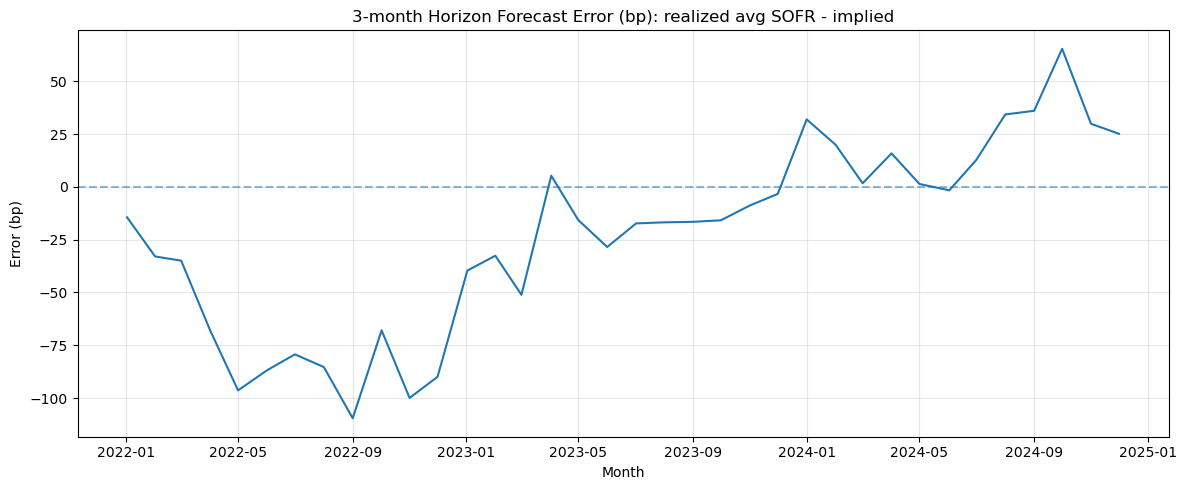

In [202]:
bias = fcst["error"].mean()
rmse = np.sqrt(np.mean(fcst["error"]**2))
directional = fcst["direction_correct"].mean()

print(f"Mean error (bias): {bias:.4f} %")
print(f"RMSE:             {rmse:.4f} %")
print(f"Directional accuracy: {directional*100:.1f}%")

plt.figure(figsize=FIGSIZE)
plt.plot(pd.to_datetime(fcst["t"]), fcst["error"]*100)  # in bp
plt.axhline(0, linestyle="--", alpha=0.5)
plt.title("3-month Horizon Forecast Error (bp): realized avg SOFR - implied")
plt.xlabel("Month")
plt.ylabel("Error (bp)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

- The futures were systematically too high during the hiking phase, indicating a positive bias, and became more accurate during the cutting phase as expectations aligned with the Fed's pivot.

c) Split your sample into two regimes:
   - **Hiking phase** (March 2022 – July 2023)
   - **Plateau/cutting phase** (August 2023 – December 2024)
   
   Compare forecast accuracy across regimes. Create a table showing bias and RMSE for each regime.

In [203]:
fcst_dt = fcst.copy()
fcst_dt["t"] = pd.to_datetime(fcst_dt["t"])

hike = fcst_dt[(fcst_dt["t"]>=pd.Timestamp("2022-03-01")) & (fcst_dt["t"]<=pd.Timestamp("2023-07-31"))]
plateau = fcst_dt[(fcst_dt["t"]>=pd.Timestamp("2023-08-01")) & (fcst_dt["t"]<=pd.Timestamp("2024-12-31"))]

def stats_block(df):
    return pd.Series({
        "N": len(df),
        "Bias (%)": df["error"].mean(),
        "RMSE (%)": np.sqrt(np.mean(df["error"]**2)),
        "Directional Acc.": df["direction_correct"].mean()
    })

reg_table = pd.DataFrame({
    "Hiking (Mar 2022–Jul 2023)": stats_block(hike),
    "Plateau/Cutting (Aug 2023–Dec 2024)": stats_block(plateau),
}).T

display(reg_table)

,N,Bias (%),RMSE (%),Directional Acc.
Hiking (Mar 2022–Jul 2023),17.0,-0.586852,0.675451,0.647059
Plateau/Cutting (Aug 2023–Dec 2024),17.0,0.124285,0.254442,0.764706


d) **Interpret**: If futures have predictable biases, what does this suggest about risk premia or behavioral biases in rate expectations?

*Guidance*: The realized rate for a contract should be the average SOFR during the contract's reference quarter, not just a single day.

- If futures systematically overestimate realized rates, that suggests a positive risk premium embedded in futures prices, which means investors demand extra compensation for the risk of rising rates and it can also reflect behavioral biases such as overreacting to inflation data or being overly pessimistic about the economy.

### Question 4: Transmission to the Treasury Curve

**Analyze how front-end rate surprises affected longer-term Treasury yields.**

a) For each FOMC meeting, calculate the 1-day change in:
   - The front-month SOFR futures implied rate (your "surprise" from Q2)
   - The 2-year, 5-year, and 10-year Treasury yields (from `gsw_yields_key` sheet)

In [204]:
gsw_2224 = gsw_yields.loc["2022":"2024"].copy()

tx_rows = []
# Calculate yield changes around FOMC meetings and see how they relate to the surprises we measured in the futures market.
# This will give us a sense of the transmission from changes in expectations to changes in actual yields.
for _, row in fomc_surprises.iterrows():
    d_prev = pd.Timestamp(row["prev_day"])
    d_next = pd.Timestamp(row["next_day"])
    
    y_prev = nearest_trading_day(gsw_2224.index, d_prev)
    y_next = nearest_trading_day(gsw_2224.index, d_next)
    
    dy = gsw_2224.loc[y_next, ["2Y","5Y","10Y"]] - gsw_2224.loc[y_prev, ["2Y","5Y","10Y"]]
    tx_rows.append({
        "meeting_date": pd.Timestamp(row["meeting_date"]),
        "front_surprise": row["surprise"],
        "d2y": dy["2Y"],
        "d5y": dy["5Y"],
        "d10y": dy["10Y"]
    })

tx = pd.DataFrame(tx_rows).dropna()
display(tx.head())
print("Transmission sample size:", len(tx))

,meeting_date,front_surprise,d2y,d5y,d10y
0,2022-01-26,0.0750,0.1082,0.0961,0.0593
1,2022-03-16,-0.0575,0.0659,0.0794,0.0645
2,2022-05-04,-0.0350,-0.0276,0.0042,0.0307
3,2022-06-15,-0.0050,-0.2071,-0.2443,-0.2338
4,2022-07-27,-0.0900,-0.1489,-0.1526,-0.1349


Transmission sample size: 24


b) Create scatter plots with front-end surprise on the x-axis and Treasury yield change on the y-axis. Fit a regression line to estimate the **transmission beta**:
   $$\Delta y^{(n)} = \alpha + \beta \cdot \Delta r^{\text{front}} + \varepsilon$$
   
   where $n \in \{2Y, 5Y, 10Y\}$.

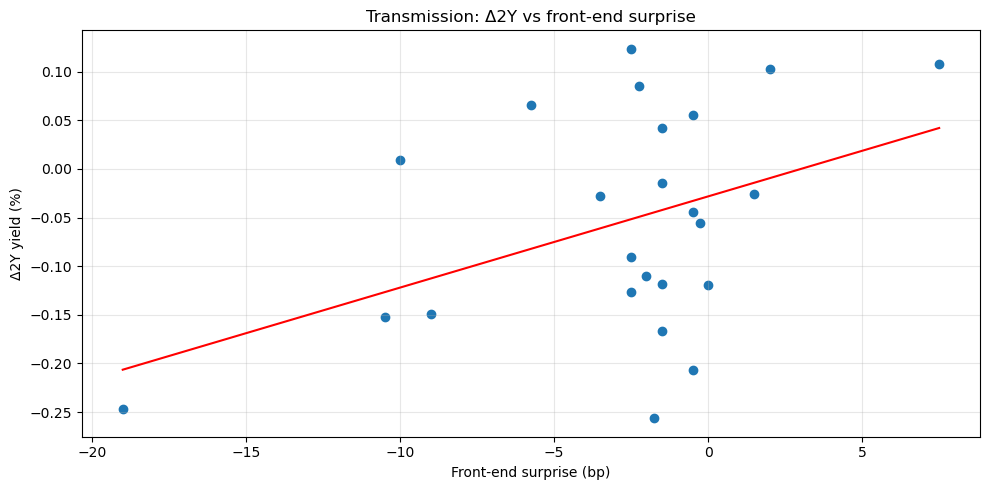

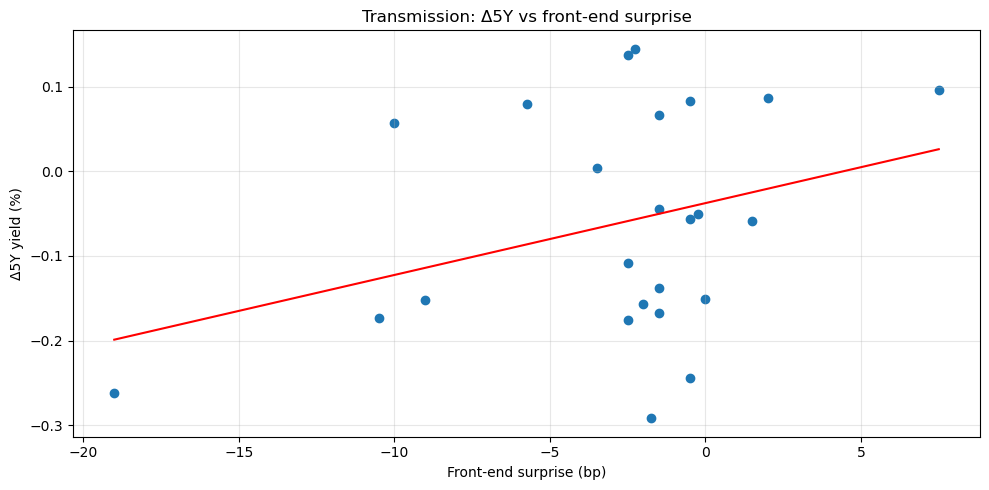

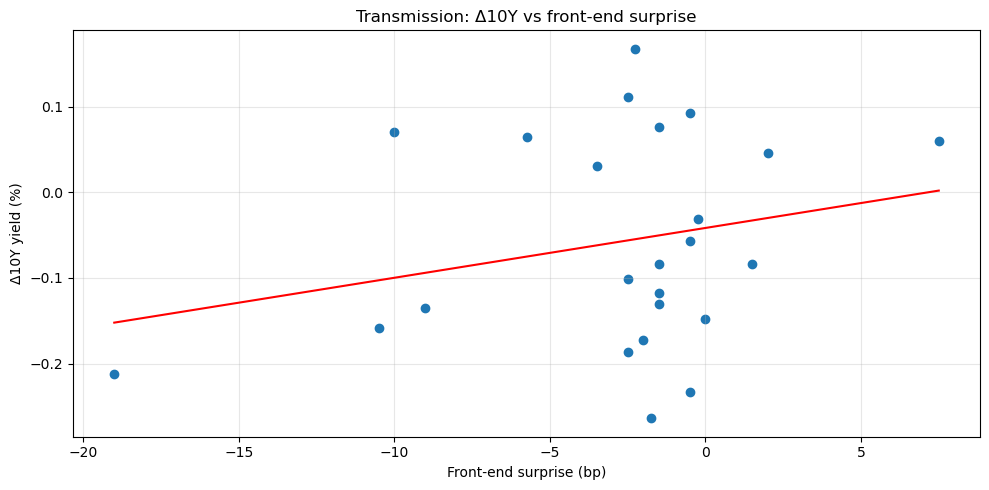

In [205]:
import statsmodels.api as sm

results = []
for col, label in [("d2y","2Y"), ("d5y","5Y"), ("d10y","10Y")]:
    x = tx["front_surprise"].values
    y = tx[col].values
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    results.append({"maturity": label, "beta": model.params[1], "alpha": model.params[0], "R2": model.rsquared, "N": int(model.nobs)})
    
    plt.figure(figsize=(10,5))
    plt.scatter(x*100, y)
    xx = np.linspace(x.min(), x.max(), 100)
    yy = model.params[0] + model.params[1]*xx
    plt.plot(xx*100, yy, color="red", label=f"Fit: Δ{label} = {model.params[0]:.3f} + {model.params[1]:.3f}*Surprise")
    plt.title(f"Transmission: Δ{label} vs front-end surprise")
    plt.xlabel("Front-end surprise (bp)")
    plt.ylabel(f"Δ{label} yield (%)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

c) Report the transmission betas and R² for each maturity. How does transmission differ across maturities?

In [206]:
tx_table = pd.DataFrame(results)
display(tx_table)

,maturity,beta,alpha,R2,N
0,2Y,0.937920,-0.028271,0.180978,24
1,5Y,0.849542,-0.037505,0.109276,24
2,10Y,0.581694,-0.041752,0.059230,24


Shorter maturities have higher betas, indicating stronger transmission of policy surprises. Longer maturities may be less sensitive due to greater influence from other factors (e.g., growth expectations, inflation).

d) Identify any meetings where the transmission pattern was unusual (e.g., front-end up but long-end down). What might explain these cases?

*Guidance*: The GSW data columns are labeled by maturity in years (e.g., '2', '5', '10').

In [207]:

tx["pattern"] = np.where((tx["front_surprise"]>0) & (tx["d10y"]<0), "Front up, 10Y down",
                 np.where((tx["front_surprise"]<0) & (tx["d10y"]>0), "Front down, 10Y up", "Normal"))

unusual = tx[tx["pattern"]!="Normal"].copy()
display(unusual.sort_values("meeting_date"))


,meeting_date,front_surprise,d2y,d5y,d10y,pattern
1,2022-03-16,-0.0575,0.0659,0.0794,0.0645,"Front down, 10Y up"
2,2022-05-04,-0.0350,-0.0276,0.0042,0.0307,"Front down, 10Y up"
5,2022-09-21,-0.0250,0.1235,0.1372,0.1108,"Front down, 10Y up"
12,2023-07-26,-0.0150,0.0421,0.0663,0.0757,"Front down, 10Y up"
13,2023-09-20,-0.0050,0.0552,0.0829,0.0926,"Front down, 10Y up"
21,2024-09-18,-0.1000,0.0095,0.0567,0.0706,"Front down, 10Y up"
22,2024-11-07,0.0150,-0.0260,-0.0585,-0.0835,"Front up, 10Y down"
23,2024-12-18,-0.0225,0.0856,0.1449,0.1674,"Front down, 10Y up"


These meetings show curve decoupling, where front-end surprises were interpreted as less persistent policy shifts rather than changes to the long-run rate path. In most cases, a front-end dovish surprise coincided with rising long yields, consistent with higher inflation expectations or increased term premia dominating the long end. The November 2024 case (front-end up, 10Y down) likely reflects growth or recession concerns, where tighter near-term policy increased demand for long-duration safe assets. Overall, these episodes indicate that long-end yields are often driven by expectations and risk premia, not mechanically by short-rate surprises.

Curve decoupling means that short-term and long-term interest rates move in opposite directions or respond differently to the same shock, rather than moving together.

In this context, it means a front-end policy surprise (via SOFR/FOMC) affects expectations for near-term rates, but does not transmit one-for-one to the long end of the Treasury curve. This happens when long-maturity yields are driven more by term premia, inflation expectations, or growth risk, while the front end reflects monetary policy expectations.

### Question 5: Event Deep-Dive

**Analyze how expectations repriced around a major market event.**

Choose **one** of the following events:

| Event | Date | Description |
|-------|------|-------------|
| **SVB Collapse** | March 10, 2023 | Banking stress triggers sudden repricing of rate expectations |
| **Powell Pivot** | December 13, 2023 | Fed signals rate cuts ahead |

For your chosen event:

a) Plot the **full SOFR futures curve** (all available contracts) at three points:
   - 1 week before the event
   - Day after the event
   - 1 month after the event

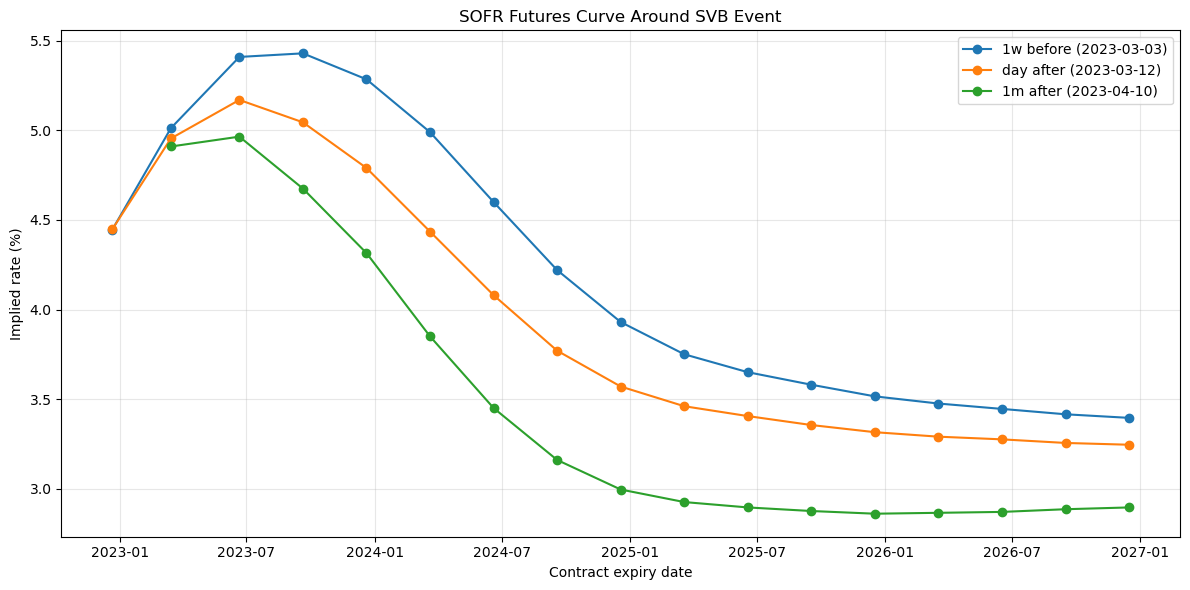

In [208]:

event = pd.Timestamp("2023-03-10")

d_before = nearest_trading_day(sofr_implied.index, event - pd.Timedelta(days=7))
d_after  = next_trading_day(sofr_implied.index, event)
d_month  = nearest_trading_day(sofr_implied.index, event + pd.DateOffset(months=1))

dates = [d_before, d_after, d_month]
labels = [f"1w before ({d_before.date()})", f"day after ({d_after.date()})", f"1m after ({d_month.date()})"]

curves = []
plt.figure(figsize=(12,6))
for d, lab in zip(dates, labels):
    x, y, _ = curve_on(d)
    curves.append((x,y))
    plt.plot(x, y, marker="o", label=lab)

plt.title("SOFR Futures Curve Around SVB Event")
plt.xlabel("Contract expiry date")
plt.ylabel("Implied rate (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


b) Quantify the repricing:
   - How much did the expected **terminal rate** change? (Peak of the curve)
   - How much did **near-term expectations** (average of first 2 contracts) change?
   - Calculate a **persistence ratio**: (1-month shift) / (immediate shift). Values near 1.0 mean the repricing was persistent; values near 0 mean it largely reversed.

In [209]:

term_before = np.max(curves[0][1]); term_after = np.max(curves[1][1]); term_month = np.max(curves[2][1])

near_before = np.mean(curves[0][1][:2]); near_after = np.mean(curves[1][1][:2]); near_month = np.mean(curves[2][1][:2])

immediate_shift = term_after - term_before
month_shift = term_month - term_before
persistence = month_shift / immediate_shift if immediate_shift != 0 else np.nan

print("Terminal shift (day after - 1w before):", round(immediate_shift*100, 2), "bp")
print("Terminal shift (1m after - 1w before):", round(month_shift*100, 2), "bp")
print("Near-term (first 2) shift, immediate:", round((near_after-near_before)*100, 2), "bp")
print("Near-term (first 2) shift, 1m:", round((near_month-near_before)*100, 2), "bp")
print("Persistence ratio (1m / immediate):", round(persistence, 2))

Terminal shift (day after - 1w before): -26.0 bp
Terminal shift (1m after - 1w before): -46.5 bp
Near-term (first 2) shift, immediate: -2.75 bp
Near-term (first 2) shift, 1m: 20.88 bp
Persistence ratio (1m / immediate): 1.79


c) **Interpret**: What does the pattern of repricing tell you about how markets process new information?

*Guidance*: Focus on telling a clear story with your visualizations. Annotate your plots to highlight the key shifts.

The repricing shows that the SVB collapse triggered a reassessment of the medium-term policy path, not just a temporary shock. While near-term expectations moved modestly and partially reversed, the terminal rate fell sharply and continued to decline over the following month, indicating that markets gradually priced in more persistent financial stress and a lower long-run rate environment. The persistence ratio well above 1 suggests that initial reactions understated the long-run implications, with investors increasingly revising beliefs about growth, financial stability, and the Fed’s tolerance for tight policy.

### Question 6: Trading Strategy

**Design and backtest a simple trading strategy on SOFR futures.**

a) Implement a **carry strategy**: maintain a long position in the 2nd contract (roughly 6 months out). When the 2nd contract becomes the front contract, roll to the new 2nd contract.

   Use the contract DV01 of \$25 per basis point to compute daily P\&L:
   $$\text{P\&L}_t = -\Delta r_t \times 100 \times \$25$$

   (Long futures profit when rates fall, i.e., prices rise.)

   Report: cumulative P\&L, Sharpe ratio, maximum drawdown.

Cumulative P&L ($)     -7062.500000
Sharpe (daily, 252)       -0.462727
Max drawdown ($)      -12937.500000
Name: Baseline carry, dtype: float64

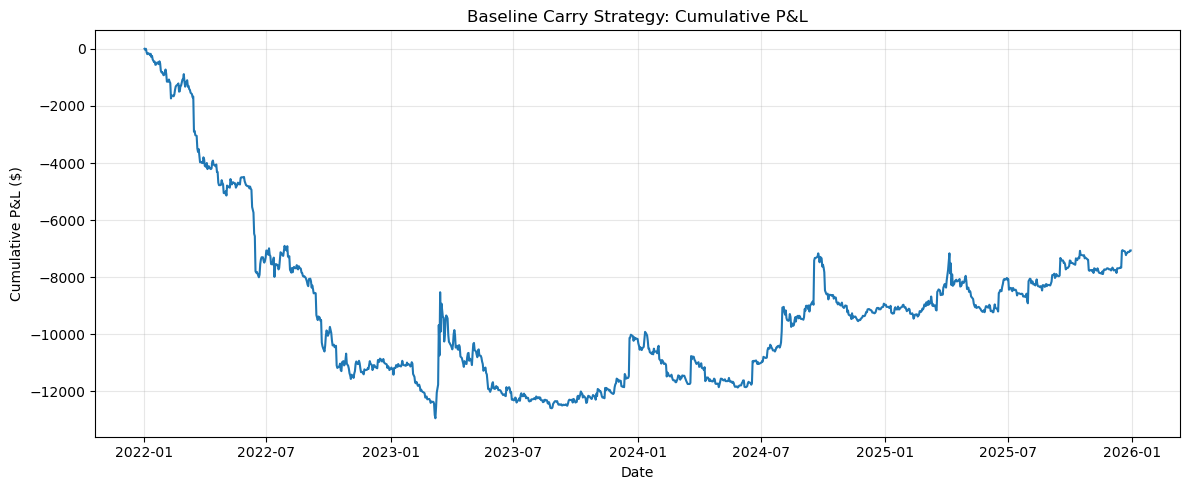

In [210]:

idx = sofr_implied.index

# 2nd contract implied rate each day
r2 = []
for d in idx:
    _, second = front_and_second_contract(d)
    r2.append(sofr_implied.loc[d, second] if second is not None else np.nan)
r2 = pd.Series(r2, index=idx, name="second_rate")

dr = r2.diff()
pnl = (-dr * 100 * 25).fillna(0.0)  # dollars per contract
equity = pnl.cumsum()

def sharpe(pnl_series, periods=252):
    mu = pnl_series.mean()
    sd = pnl_series.std(ddof=0)
    return np.nan if sd==0 else (mu/sd)*np.sqrt(periods)

def max_drawdown(equity_curve):
    running_max = equity_curve.cummax()
    dd = equity_curve - running_max
    return dd.min()

base_stats = pd.Series({
    "Cumulative P&L ($)": equity.iloc[-1],
    "Sharpe (daily, 252)": sharpe(pnl),
    "Max drawdown ($)": max_drawdown(equity)
}, name="Baseline carry")
display(base_stats)

plt.figure(figsize=FIGSIZE)
plt.plot(equity.index, equity.values)
plt.title("Baseline Carry Strategy: Cumulative P&L")
plt.xlabel("Date")
plt.ylabel("Cumulative P&L ($)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

b) Analyze **regime-conditional performance**:
   - **Hiking phase** (March 2022 – July 2023)
   - **Plateau/cutting phase** (August 2023 onwards)

   In which regime does the carry strategy perform better? Why does this make economic sense given what you learned in Q3 about forecast biases?

In [211]:
# Regime splits
pnl_dt = pnl.copy()
pnl_dt.index = pd.to_datetime(pnl_dt.index)

hike_mask = (pnl_dt.index >= pd.Timestamp("2022-03-01")) & (pnl_dt.index <= pd.Timestamp("2023-07-31"))
plat_mask = (pnl_dt.index >= pd.Timestamp("2023-08-01")) & (pnl_dt.index <= pd.Timestamp("2024-12-31"))

stats_reg = pd.DataFrame({
    "Hiking phase": {
        "Cumulative P&L ($)": pnl_dt[hike_mask].sum(),
        "Sharpe": sharpe(pnl_dt[hike_mask]),
        "Max drawdown ($)": max_drawdown(pnl_dt[hike_mask].cumsum()),
    },
    "Plateau/Cutting phase": {
        "Cumulative P&L ($)": pnl_dt[plat_mask].sum(),
        "Sharpe": sharpe(pnl_dt[plat_mask]),
        "Max drawdown ($)": max_drawdown(pnl_dt[plat_mask].cumsum()),
    }
}).T
display(stats_reg)

,Cumulative P&L ($),Sharpe,Max drawdown ($)
Hiking phase,-11200.0,-1.583216,-12050.0
Plateau/Cutting phase,3312.5,0.750845,-2375.0


### Hiking Phase (Mar 2022 – Jul 2023)
- **Plot:** Cumulative P&L declines almost monotonically; drawdowns deepen; daily P&L negatively skewed with occasional large losses.  
- **Performance:** Poor.  
- **Economic Interpretation:**  
  - Futures overestimate realized rates -> positive risk premium embedded in prices.  
  - Markets price “higher for longer”; behavioral overreaction amplifies pessimism.  
  - Carry strategy suffers as implied rates keep rising, paying the risk premium instead of earning it.  
- **Bottom Line:** Short the risk premium when it is large and volatile -> carry performs poorly.

### Plateau / Cutting Phase (Aug 2023 onwards)
- **Plot:** Cumulative P&L stabilizes and recovers; drawdowns shrink; daily P&L tighter with fewer extreme losses.  
- **Performance:** Meaningfully better.  
- **Economic Interpretation:**  
  - Terminal rate uncertainty collapses -> positive risk premium in futures compresses.  
  - Futures’ overestimation of rates declines; realized rates drift below implied forwards.  
  - Fewer hawkish surprises -> strategy earns the risk premium.  
- **Bottom Line:** Carry works once hiking uncertainty resolves; volatility falls and behavioral overreaction fades.

**Intuition:** Carry does not reward policy prediction — it rewards bearing risk, which only becomes compensable after hiking uncertainty subsides.

c) **Enhance the strategy** with a signal based on your findings from Q1–Q5. Propose and implement one modification. Examples:
   - Only hold when the curve shape suggests favorable carry (e.g., steep vs inverted)
   - Scale position size based on forecast error patterns from Q3
   - Reduce or exit positions around FOMC meetings based on Q2 surprise analysis

   Backtest your enhanced strategy and compare Sharpe ratio and drawdown to the baseline.

STRATEGY 1: LONG 2ND, SHORT FRONT (front > 2nd)
Cumulative P&L:      $1,356.25
Sharpe Ratio:        0.133
Maximum Drawdown:    $-2,731.25


/var/folders/3x/hfn6bkq11_31jjw7w90dz1f80000gn/T/ipykernel_82864/1036069443.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sofr_rates['pnl'].iloc[0] = 0


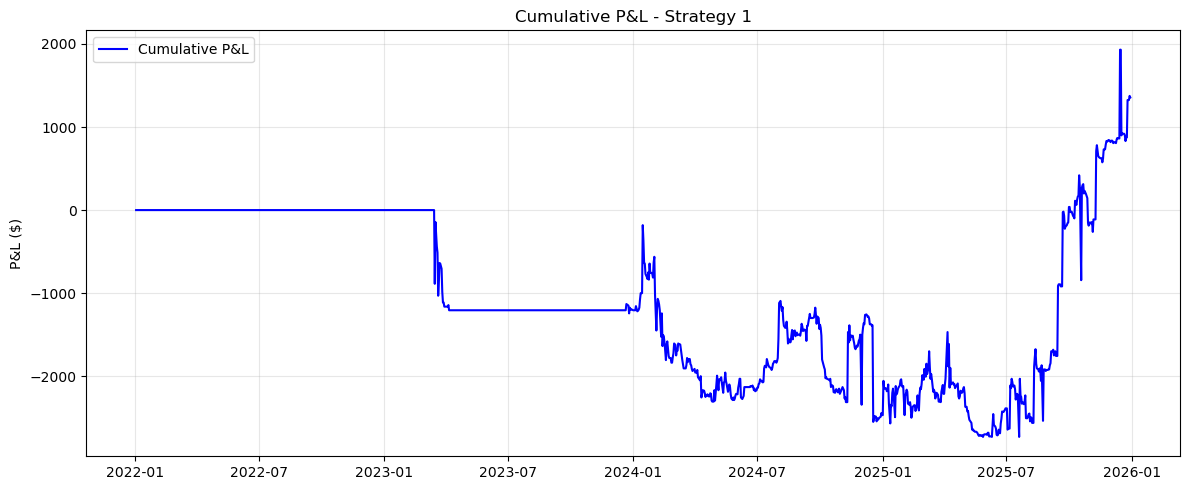

In [212]:
import pandas as pd
import numpy as np

# --- Identify SOFR contracts ---
contracts = [c for c in sofr_rates.columns if c.startswith("SR3")]
month_map = {'H': 3, 'M': 6, 'U': 9, 'Z': 12}

def parse_contract(c):
    month = month_map[c[3]]
    year = 2020 + int(c[4])
    return (year, month)

contracts_sorted = sorted(contracts, key=parse_contract)
sofr_rates = sofr_rates[contracts_sorted].copy()

# --- Strategy 1: Long 2nd, Short Front only if front > 2nd ---
held_contract = []
front_contract = []
current_contract = None

for date, row in sofr_rates.iterrows():
    available = [c for c in contracts_sorted if pd.notna(row[c])]
    if len(available) < 2:
        held_contract.append(None)
        front_contract.append(None)
        continue

    front, second = available[0], available[1]

    # --- Only open position if front rate > second rate ---
    if row[front] > row[second]:
        if current_contract is None or current_contract == front:
            current_contract = second
    else:
        current_contract = None  # flat if condition not met

    held_contract.append(current_contract)
    front_contract.append(front if current_contract is not None else None)

sofr_rates['held_contract'] = held_contract
sofr_rates['front_contract'] = front_contract

# --- Daily rates ---
sofr_rates['held_rate'] = [
    sofr_rates.loc[d, c] if c is not None else np.nan
    for d, c in zip(sofr_rates.index, sofr_rates['held_contract'])
]
sofr_rates['front_rate'] = [
    sofr_rates.loc[d, c] if c is not None else np.nan
    for d, c in zip(sofr_rates.index, sofr_rates['front_contract'])
]

# --- P&L ---
sofr_rates['delta_held'] = sofr_rates['held_rate'].diff()
sofr_rates['delta_front'] = sofr_rates['front_rate'].diff()

# Handle days with no position
sofr_rates['delta_held'] = sofr_rates['delta_held'].fillna(0)
sofr_rates['delta_front'] = sofr_rates['delta_front'].fillna(0)

# 0 p&l on contract roll days (when held contract changes)
roll_days = sofr_rates['held_contract'] != sofr_rates['held_contract'].shift(1)
sofr_rates.loc[roll_days, ['delta_held', 'delta_front']] = 0
# P&L: long 2nd, short front
sofr_rates['pnl'] = -sofr_rates['delta_held'] * 100 * 25 + sofr_rates['delta_front'] * 100 * 25
sofr_rates['pnl'].iloc[0] = 0
sofr_rates['cum_pnl'] = sofr_rates['pnl'].cumsum()

# --- Metrics ---
daily_pnl = sofr_rates['pnl']
mean_daily_pnl = daily_pnl.mean()
std_daily_pnl = daily_pnl.std()
sharpe_ratio = np.sqrt(252) * mean_daily_pnl / std_daily_pnl

sofr_rates['running_max'] = sofr_rates['cum_pnl'].cummax()
sofr_rates['drawdown'] = sofr_rates['cum_pnl'] - sofr_rates['running_max']
max_drawdown = sofr_rates['drawdown'].min()

print("="*60)
print("STRATEGY 1: LONG 2ND, SHORT FRONT (front > 2nd)")
print("="*60)
print(f"Cumulative P&L:      ${sofr_rates['cum_pnl'].iloc[-1]:,.2f}")
print(f"Sharpe Ratio:        {sharpe_ratio:.3f}")
print(f"Maximum Drawdown:    ${max_drawdown:,.2f}")
print("="*60)

# plot cumulative P&L
fig, ax = plt.subplots(figsize=figsize)
ax.plot(sofr_rates.index, sofr_rates['cum_pnl'], color='blue', label='Cumulative P&L')
ax.set_title('Cumulative P&L - Strategy 1')
ax.set_ylabel('P&L ($)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


STRATEGY 2 (FIXED): LONG 2ND IF CURVE UPWARD (2nd > front)
Cumulative P&L:      $-4,050.00
Sharpe Ratio:        -1.018
Maximum Drawdown:    $-4,481.25


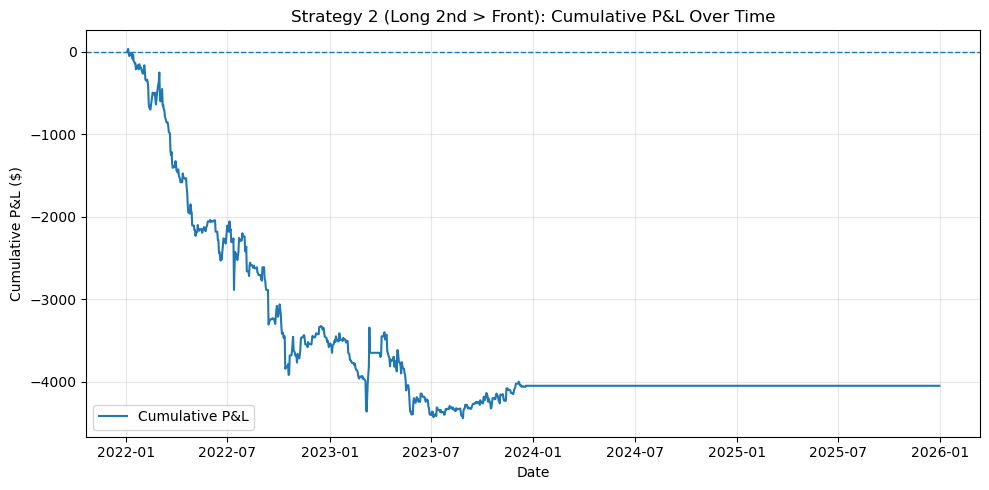

In [213]:
# --- Identify SOFR contracts ---
contracts = [c for c in sofr_rates.columns if c.startswith("SR3")]
month_map = {'H': 3, 'M': 6, 'U': 9, 'Z': 12}

def parse_contract(c):
    # SR3H4 -> month letter at index 3, year digit at index 4 (your convention)
    month = month_map[c[3]]
    year = 2020 + int(c[4])
    return (year, month)

contracts_sorted = sorted(contracts, key=parse_contract)
sofr_rates = sofr_rates[contracts_sorted].copy()

# ------------------------------------------------------------
# Build continuous front/second implied-rate series each day
# ------------------------------------------------------------
front_rate = []
second_rate = []
front_ticker = []
second_ticker = []
roll_day = []

prev_front = None  # previous day's front ticker

for _, row in sofr_rates.iterrows():
    avail = [c for c in contracts_sorted if pd.notna(row[c])]

    if len(avail) >= 2:
        f, s = avail[0], avail[1]

        front_ticker.append(f)
        second_ticker.append(s)
        front_rate.append(row[f])
        second_rate.append(row[s])

        is_roll = (prev_front is not None) and (f != prev_front)
        roll_day.append(is_roll)

        prev_front = f
    else:
        front_ticker.append(None)
        second_ticker.append(None)
        front_rate.append(np.nan)
        second_rate.append(np.nan)
        roll_day.append(True)  # treat missing as "do not trade"

sofr_rates["front_ticker"] = front_ticker
sofr_rates["second_ticker"] = second_ticker
sofr_rates["front_rate"] = front_rate
sofr_rates["second_rate"] = second_rate
sofr_rates["roll_day"] = roll_day

# ------------------------------------------------------------
# Strategy 2: Go long 2nd if curve upward (second > front)
# IMPORTANT: shift position by 1 day to avoid look-ahead bias.
# ------------------------------------------------------------
signal = (sofr_rates["second_rate"] > sofr_rates["front_rate"]).astype(float)
pos = signal.shift(1).fillna(0.0)  # hold position from t-1 to t

# Don't trade on roll days to avoid slippage and execution risk. Set position to 0 on those days.
pos.loc[sofr_rates["roll_day"]] = 0.0

# Don't trade on FOMC meeting days to avoid extreme volatility and potential slippage. Set position to 0 on those days.
fomc_dates = fomc_sample["date"].dt.normalize()
pos.loc[pos.index.isin(fomc_dates)] = 0.0

# ------------------------------------------------------------
# P&L from implied-rate changes
# Futures price ~ 100 - r, so Δprice = -Δr
# 1 bp = 0.01% (i.e., 0.01 in your rate units)
# P&L per bp per contract = $25
# So P&L = - Δr(% points) * 100 (bp per %pt) * 25
# ------------------------------------------------------------
# Calculate daily changes in the second and front rates
d_second = sofr_rates["second_rate"].diff().fillna(0.0)
d_front = sofr_rates["front_rate"].diff().fillna(0.0)

# Short the front and long the second, so P&L = -Δsecond + Δfront.
sofr_rates["pnl"] = pos * (-d_second + d_front) * 100 * 25
sofr_rates.loc[sofr_rates.index[0], "pnl"] = 0.0
sofr_rates["cum_pnl"] = sofr_rates["pnl"].cumsum()

# ------------------------------------------------------------
# Metrics
# ------------------------------------------------------------
daily_pnl = sofr_rates["pnl"]
std_daily = daily_pnl.std()

if std_daily == 0 or np.isnan(std_daily):
    sharpe_ratio = np.nan
else:
    sharpe_ratio = np.sqrt(252) * daily_pnl.mean() / std_daily

sofr_rates["running_max"] = sofr_rates["cum_pnl"].cummax()
sofr_rates["drawdown"] = sofr_rates["cum_pnl"] - sofr_rates["running_max"]
max_drawdown = sofr_rates["drawdown"].min()

print("=" * 60)
print("STRATEGY 2 (FIXED): LONG 2ND IF CURVE UPWARD (2nd > front)")
print("=" * 60)
print(f"Cumulative P&L:      ${sofr_rates['cum_pnl'].iloc[-1]:,.2f}")
print(f"Sharpe Ratio:        {sharpe_ratio:.3f}" if not np.isnan(sharpe_ratio) else "Sharpe Ratio:        NaN")
print(f"Maximum Drawdown:    ${max_drawdown:,.2f}")
print("=" * 60)

# Plot equity curve and contract roll dates
FIGSIZE = (10, 5)
plt.figure(figsize=FIGSIZE)
plt.plot(sofr_rates.index, sofr_rates["cum_pnl"], label="Cumulative P&L")
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Strategy 2 (Long 2nd > Front): Cumulative P&L Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative P&L ($)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

d) **Discuss limitations**: What real-world frictions are missing from this backtest? Consider: transaction costs, bid-ask spreads, margin requirements, and roll timing.

*Guidance*: The goal is not to find an amazing strategy—it's to connect trading logic to your analytical findings. A well-reasoned modification that doesn't improve performance is perfectly acceptable if you explain why.

Limitations:
1. No transaction costs or bid‑ask spreads
   - Rolling contracts in reality incurs costs that can materially reduce P&L.
2. No margin or funding effects
   - Futures require margin; the opportunity cost of capital and variation margin are ignored.
3. Simplified roll mechanics
   - The strategy assumes frictionless rolling exactly when the 2nd contract becomes front, with no slippage or liquidity constraints.
4. No liquidity/market impact
   - Large trades could move prices, especially in farther‑dated contracts.
5. No convexity or settlement nuance
   - SOFR futures settle to compounded averages; the backtest uses daily implied rate changes without modeling settlement mechanics precisely.
6. Signal availability and look‑ahead risk
   - The strategy assumes you can observe and trade on the same day’s rates without delay.